In [1]:
import pandas as pd
import numpy as np

from scipy.stats import zscore
import statsmodels.api as sm

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.impute import KNNImputer

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import matplotlib.pyplot as plt
import seaborn as sns

import pickle
import json

import warnings
warnings.filterwarnings('ignore')

# 1. Problem Statement

# 2. Data Gathering

In [2]:
sales_df = pd.read_csv(r'G:\DataScience\Assignments Solutions\Regression\Sales_Data\Data\Sales_data.csv')
sales_df

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.300,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.920,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.500,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.200,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.930,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052
...,...,...,...,...,...,...,...,...,...,...,...,...
8518,FDF22,6.865,Low Fat,0.056783,Snack Foods,214.5218,OUT013,1987,High,Tier 3,Supermarket Type1,2778.3834
8519,FDS36,8.380,Regular,0.046982,Baking Goods,108.1570,OUT045,2002,NaN,Tier 2,Supermarket Type1,549.2850
8520,NCJ29,10.600,Low Fat,0.035186,Health and Hygiene,85.1224,OUT035,2004,Small,Tier 2,Supermarket Type1,1193.1136
8521,FDN46,7.210,Regular,0.145221,Snack Foods,103.1332,OUT018,2009,Medium,Tier 3,Supermarket Type2,1845.5976


# 3. EDA

In [3]:
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [4]:
sales_df['Item_Fat_Content'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 8523 entries, 0 to 8522
Series name: Item_Fat_Content
Non-Null Count  Dtype 
--------------  ----- 
8523 non-null   object
dtypes: object(1)
memory usage: 66.7+ KB


In [5]:
sales_df['Item_Fat_Content'].value_counts()

Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

In [6]:
sales_df['Item_Fat_Content'].loc[sales_df['Item_Fat_Content'] == 'LF'] = 'Low Fat'
sales_df['Item_Fat_Content'].loc[sales_df['Item_Fat_Content'] == 'low fat'] = 'Low Fat'
sales_df['Item_Fat_Content'].loc[sales_df['Item_Fat_Content'] == 'reg'] = 'Regular'

sales_df['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

In [7]:
sales_df = pd.get_dummies(sales_df, columns = ['Item_Fat_Content'])
sales_df.head()

,Item_Identifier,Item_Weight,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular
0,FDA15,9.30,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,1,0
1,DRC01,5.92,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,0,1
2,FDN15,17.50,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,1,0
3,FDX07,19.20,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800,0,1
4,NCD19,8.93,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052,1,0


In [8]:
sales_df['Item_Type'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 8523 entries, 0 to 8522
Series name: Item_Type
Non-Null Count  Dtype 
--------------  ----- 
8523 non-null   object
dtypes: object(1)
memory usage: 66.7+ KB


In [9]:
sales_df['Item_Type'].value_counts()

Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64

In [10]:
sales_df['Item_Type'].nunique()

16

In [11]:
sales_df = pd.get_dummies(sales_df, columns = ['Item_Type'])
sales_df.head()

,Item_Identifier,Item_Weight,Item_Visibility,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,...,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,Item_Type_Health and Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods
0,FDA15,9.30,0.016047,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,...,0,0,0,0,0,0,0,0,0,0
1,DRC01,5.92,0.019278,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,...,0,0,0,0,0,0,0,0,1,0
2,FDN15,17.50,0.016760,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,...,0,0,0,0,1,0,0,0,0,0
3,FDX07,19.20,0.000000,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800,...,1,0,0,0,0,0,0,0,0,0
4,NCD19,8.93,0.000000,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052,...,0,0,0,1,0,0,0,0,0,0


In [12]:
sales_df['Outlet_Establishment_Year'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 8523 entries, 0 to 8522
Series name: Outlet_Establishment_Year
Non-Null Count  Dtype
--------------  -----
8523 non-null   int64
dtypes: int64(1)
memory usage: 66.7 KB


In [13]:
sales_df['Outlet_Establishment_Year'].value_counts().sort_index()

1985    1463
1987     932
1997     930
1998     555
1999     930
2002     929
2004     930
2007     926
2009     928
Name: Outlet_Establishment_Year, dtype: int64

In [14]:
sales_df['Outlet_Establishment_Year'].replace({1985 : 0, 1987 : 1, 1997 : 2, 1998 : 3, 1999 : 4,
                                              2002 : 5, 2004 : 6, 2007 : 7, 2009 : 8}, inplace = True)
json_data = {'Outlet_Establishment_Year' : {1985 : 0, 1987 : 1, 1997 : 2, 1998 : 3, 1999 : 4,
                                            2002 : 5, 2004 : 6, 2007 : 7, 2009 : 8}}

sales_df.head()

,Item_Identifier,Item_Weight,Item_Visibility,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,...,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,Item_Type_Health and Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods
0,FDA15,9.30,0.016047,249.8092,OUT049,4,Medium,Tier 1,Supermarket Type1,3735.1380,...,0,0,0,0,0,0,0,0,0,0
1,DRC01,5.92,0.019278,48.2692,OUT018,8,Medium,Tier 3,Supermarket Type2,443.4228,...,0,0,0,0,0,0,0,0,1,0
2,FDN15,17.50,0.016760,141.6180,OUT049,4,Medium,Tier 1,Supermarket Type1,2097.2700,...,0,0,0,0,1,0,0,0,0,0
3,FDX07,19.20,0.000000,182.0950,OUT010,3,NaN,Tier 3,Grocery Store,732.3800,...,1,0,0,0,0,0,0,0,0,0
4,NCD19,8.93,0.000000,53.8614,OUT013,1,High,Tier 3,Supermarket Type1,994.7052,...,0,0,0,1,0,0,0,0,0,0


In [15]:
sales_df['Outlet_Size'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 8523 entries, 0 to 8522
Series name: Outlet_Size
Non-Null Count  Dtype 
--------------  ----- 
6113 non-null   object
dtypes: object(1)
memory usage: 66.7+ KB


In [16]:
sales_df['Outlet_Size'].value_counts()

Medium    2793
Small     2388
High       932
Name: Outlet_Size, dtype: int64

In [17]:
sales_df['Outlet_Size'].replace({'Small' : 0, 'Medium' : 1, 'High' : 2}, inplace = True)
json_data['Outlet_Size'] = {'Small' : 0, 'Medium' : 1, 'High' : 2}

sales_df.head()

,Item_Identifier,Item_Weight,Item_Visibility,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,...,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,Item_Type_Health and Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods
0,FDA15,9.30,0.016047,249.8092,OUT049,4,1.0,Tier 1,Supermarket Type1,3735.1380,...,0,0,0,0,0,0,0,0,0,0
1,DRC01,5.92,0.019278,48.2692,OUT018,8,1.0,Tier 3,Supermarket Type2,443.4228,...,0,0,0,0,0,0,0,0,1,0
2,FDN15,17.50,0.016760,141.6180,OUT049,4,1.0,Tier 1,Supermarket Type1,2097.2700,...,0,0,0,0,1,0,0,0,0,0
3,FDX07,19.20,0.000000,182.0950,OUT010,3,NaN,Tier 3,Grocery Store,732.3800,...,1,0,0,0,0,0,0,0,0,0
4,NCD19,8.93,0.000000,53.8614,OUT013,1,2.0,Tier 3,Supermarket Type1,994.7052,...,0,0,0,1,0,0,0,0,0,0


In [18]:
sales_df['Outlet_Location_Type'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 8523 entries, 0 to 8522
Series name: Outlet_Location_Type
Non-Null Count  Dtype 
--------------  ----- 
8523 non-null   object
dtypes: object(1)
memory usage: 66.7+ KB


In [19]:
sales_df['Outlet_Location_Type'].value_counts()

Tier 3    3350
Tier 2    2785
Tier 1    2388
Name: Outlet_Location_Type, dtype: int64

In [20]:
sales_df['Outlet_Location_Type'].replace({'Tier 3' : 0, 'Tier 2' : 1, 'Tier 1' : 2}, inplace = True)
json_data['Outlet_Location_Type'] = {'Tier 3' : 0, 'Tier 2' : 1, 'Tier 1' : 3}
sales_df.head()

,Item_Identifier,Item_Weight,Item_Visibility,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,...,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,Item_Type_Health and Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods
0,FDA15,9.30,0.016047,249.8092,OUT049,4,1.0,2,Supermarket Type1,3735.1380,...,0,0,0,0,0,0,0,0,0,0
1,DRC01,5.92,0.019278,48.2692,OUT018,8,1.0,0,Supermarket Type2,443.4228,...,0,0,0,0,0,0,0,0,1,0
2,FDN15,17.50,0.016760,141.6180,OUT049,4,1.0,2,Supermarket Type1,2097.2700,...,0,0,0,0,1,0,0,0,0,0
3,FDX07,19.20,0.000000,182.0950,OUT010,3,NaN,0,Grocery Store,732.3800,...,1,0,0,0,0,0,0,0,0,0
4,NCD19,8.93,0.000000,53.8614,OUT013,1,2.0,0,Supermarket Type1,994.7052,...,0,0,0,1,0,0,0,0,0,0


In [21]:
sales_df['Outlet_Type'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 8523 entries, 0 to 8522
Series name: Outlet_Type
Non-Null Count  Dtype 
--------------  ----- 
8523 non-null   object
dtypes: object(1)
memory usage: 66.7+ KB


In [22]:
sales_df['Outlet_Type'].value_counts()

Supermarket Type1    5577
Grocery Store        1083
Supermarket Type3     935
Supermarket Type2     928
Name: Outlet_Type, dtype: int64

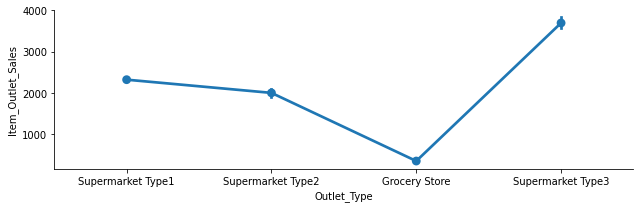

In [23]:
sns.catplot(x = 'Outlet_Type', y = 'Item_Outlet_Sales', data = sales_df, kind = 'point', height = 3, aspect = 3)

In [24]:
sales_df = pd.get_dummies(sales_df, columns = ['Outlet_Type'])
sales_df.head()

,Item_Identifier,Item_Weight,Item_Visibility,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Item_Outlet_Sales,Item_Fat_Content_Low Fat,...,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
0,FDA15,9.30,0.016047,249.8092,OUT049,4,1.0,2,3735.1380,1,...,0,0,0,0,0,0,0,1,0,0
1,DRC01,5.92,0.019278,48.2692,OUT018,8,1.0,0,443.4228,0,...,0,0,0,0,1,0,0,0,1,0
2,FDN15,17.50,0.016760,141.6180,OUT049,4,1.0,2,2097.2700,1,...,1,0,0,0,0,0,0,1,0,0
3,FDX07,19.20,0.000000,182.0950,OUT010,3,NaN,0,732.3800,0,...,0,0,0,0,0,0,1,0,0,0
4,NCD19,8.93,0.000000,53.8614,OUT013,1,2.0,0,994.7052,1,...,0,0,0,0,0,0,0,1,0,0


In [25]:
json_data['Encoded_cols'] = ['Item_Fat_Content_Low Fat', 'Item_Fat_Content_Regular', 'Item_Type_Fruits and Vegetables',
                            'Item_Type_Snack Foods', 'Item_Type_Household', 'Item_Type_Frozen Foods', 'Item_Type_Dairy',
                            'Item_Type_Canned', 'Item_Type_Baking Goods', 'Item_Type_Health and Hygiene',
                            'Item_Type_Soft Drinks', 'Item_Type_Meat', 'Item_Type_Breads', 'Item_Type_Hard Drinks',
                            'Item_Type_Others', 'Item_Type_Starchy Foods', 'Item_Type_Breakfast', 'Item_Type_Seafood',
                            'Outlet_Type_Grocery Store', 'Outlet_Type_Supermarket Type1', 'Outlet_Type_Supermarket Type2',
                            'Outlet_Type_Supermarket Type3']

# 4. Feature Selection & Feature Engineering

In [26]:
sales_df.drop(['Item_Identifier', 'Outlet_Identifier'], axis = 1, inplace = True)
sales_df.head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Item_Outlet_Sales,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Type_Baking Goods,...,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
0,9.30,0.016047,249.8092,4,1.0,2,3735.1380,1,0,0,...,0,0,0,0,0,0,0,1,0,0
1,5.92,0.019278,48.2692,8,1.0,0,443.4228,0,1,0,...,0,0,0,0,1,0,0,0,1,0
2,17.50,0.016760,141.6180,4,1.0,2,2097.2700,1,0,0,...,1,0,0,0,0,0,0,1,0,0
3,19.20,0.000000,182.0950,3,NaN,0,732.3800,0,1,0,...,0,0,0,0,0,0,1,0,0,0
4,8.93,0.000000,53.8614,1,2.0,0,994.7052,1,0,0,...,0,0,0,0,0,0,0,1,0,0


##### Dealing with Outliers

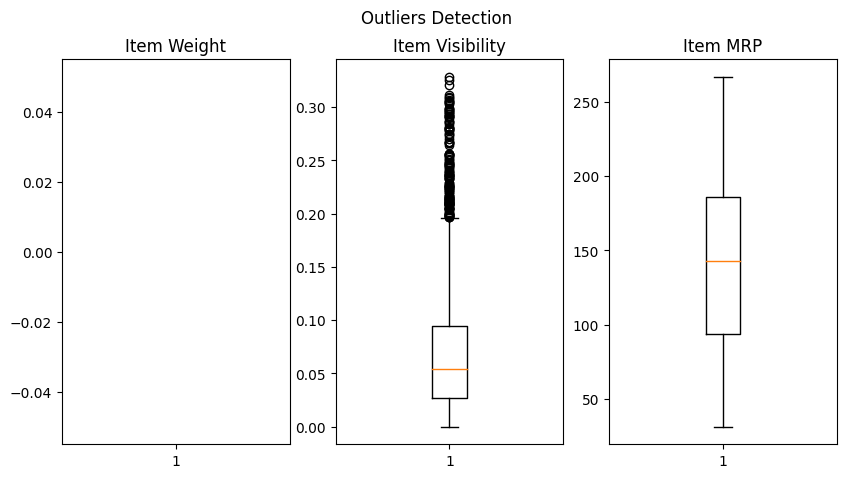

In [27]:
cont_col = ['Item_Weight', 'Item_Visibility', 'Item_MRP']

plt.figure(figsize = (10, 5))
plt.subplot(1,3,1)
plt.boxplot(sales_df['Item_Weight'])
plt.title('Item Weight')

plt.subplot(1,3,2)
plt.boxplot(sales_df['Item_Visibility'])
plt.title('Item Visibility')

plt.subplot(1,3,3)
plt.boxplot(sales_df['Item_MRP'])
plt.title('Item MRP')

plt.suptitle('Outliers Detection')
plt.show()

In [28]:
z_val = zscore(sales_df['Item_Visibility'])
outlier_index = np.where(abs(z_val) >= 3)[0]
outlier_num = len(outlier_index)
print('Number of Outliers :', outlier_num)
outlier_perc = (outlier_num / len(sales_df['Item_Visibility'])) * 100
print('Outlier Percentage :', outlier_perc)


Number of Outliers : 95
Outlier Percentage : 1.1146309984747156


In [29]:
col_mean = sales_df['Item_Visibility'].mean()
print('Mean (Before Dealing with Outliers) :', col_mean)

Mean (Before Dealing with Outliers) : 0.06613202877895108


In [30]:
def remove_outlier(col) :
    
    z_val = zscore(sales_df[col])
    outlier_index = list(np.where(abs(z_val) >= 3)[0])
    mean = sales_df[col].drop(outlier_index).mean()
    sales_df[col].iloc[outlier_index] = mean
    
remove_outlier('Item_Visibility')

In [31]:
col_mean = sales_df['Item_Visibility'].mean()
print('Mean (After Dealing with Outliers) :', col_mean)

Mean (After Dealing with Outliers) : 0.06390474693296157


<AxesSubplot:xlabel='Item_Visibility'>

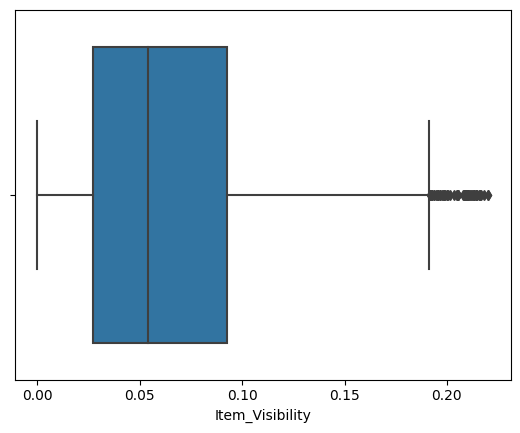

In [32]:
sns.boxplot(sales_df['Item_Visibility'])

##### Dealing with Missing Values

In [33]:
np.around((sales_df['Item_Weight'].isna().mean() * 100), 2)

17.17

In [34]:
np.around((sales_df['Outlet_Size'].isna().mean() * 100), 2)

28.28

In [35]:
impute = KNNImputer()
array = impute.fit_transform(sales_df)
sales_df = pd.DataFrame(array, columns = sales_df.columns)


In [36]:
np.around((sales_df['Item_Weight'].isna().mean() * 100), 2)

0.0

In [37]:
np.around((sales_df['Outlet_Size'].isna().mean() * 100), 2)

0.0

In [38]:
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 29 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Item_Weight                      8523 non-null   float64
 1   Item_Visibility                  8523 non-null   float64
 2   Item_MRP                         8523 non-null   float64
 3   Outlet_Establishment_Year        8523 non-null   float64
 4   Outlet_Size                      8523 non-null   float64
 5   Outlet_Location_Type             8523 non-null   float64
 6   Item_Outlet_Sales                8523 non-null   float64
 7   Item_Fat_Content_Low Fat         8523 non-null   float64
 8   Item_Fat_Content_Regular         8523 non-null   float64
 9   Item_Type_Baking Goods           8523 non-null   float64
 10  Item_Type_Breads                 8523 non-null   float64
 11  Item_Type_Breakfast              8523 non-null   float64
 12  Item_Type_Canned    

In [39]:
sales_df.head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Item_Outlet_Sales,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Type_Baking Goods,...,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
0,9.30,0.016047,249.8092,4.0,1.0,2.0,3735.1380,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,5.92,0.019278,48.2692,8.0,1.0,0.0,443.4228,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,17.50,0.016760,141.6180,4.0,1.0,2.0,2097.2700,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,19.20,0.000000,182.0950,3.0,0.4,0.0,732.3800,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,8.93,0.000000,53.8614,1.0,2.0,0.0,994.7052,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [40]:
sales_df = sales_df.astype({'Outlet_Establishment_Year' : int, 'Outlet_Size' : int, 'Outlet_Location_Type' : int})
for col in json_data['Encoded_cols'] :
    sales_df = sales_df.astype({col : int})
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 29 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Item_Weight                      8523 non-null   float64
 1   Item_Visibility                  8523 non-null   float64
 2   Item_MRP                         8523 non-null   float64
 3   Outlet_Establishment_Year        8523 non-null   int32  
 4   Outlet_Size                      8523 non-null   int32  
 5   Outlet_Location_Type             8523 non-null   int32  
 6   Item_Outlet_Sales                8523 non-null   float64
 7   Item_Fat_Content_Low Fat         8523 non-null   int32  
 8   Item_Fat_Content_Regular         8523 non-null   int32  
 9   Item_Type_Baking Goods           8523 non-null   int32  
 10  Item_Type_Breads                 8523 non-null   int32  
 11  Item_Type_Breakfast              8523 non-null   int32  
 12  Item_Type_Canned    

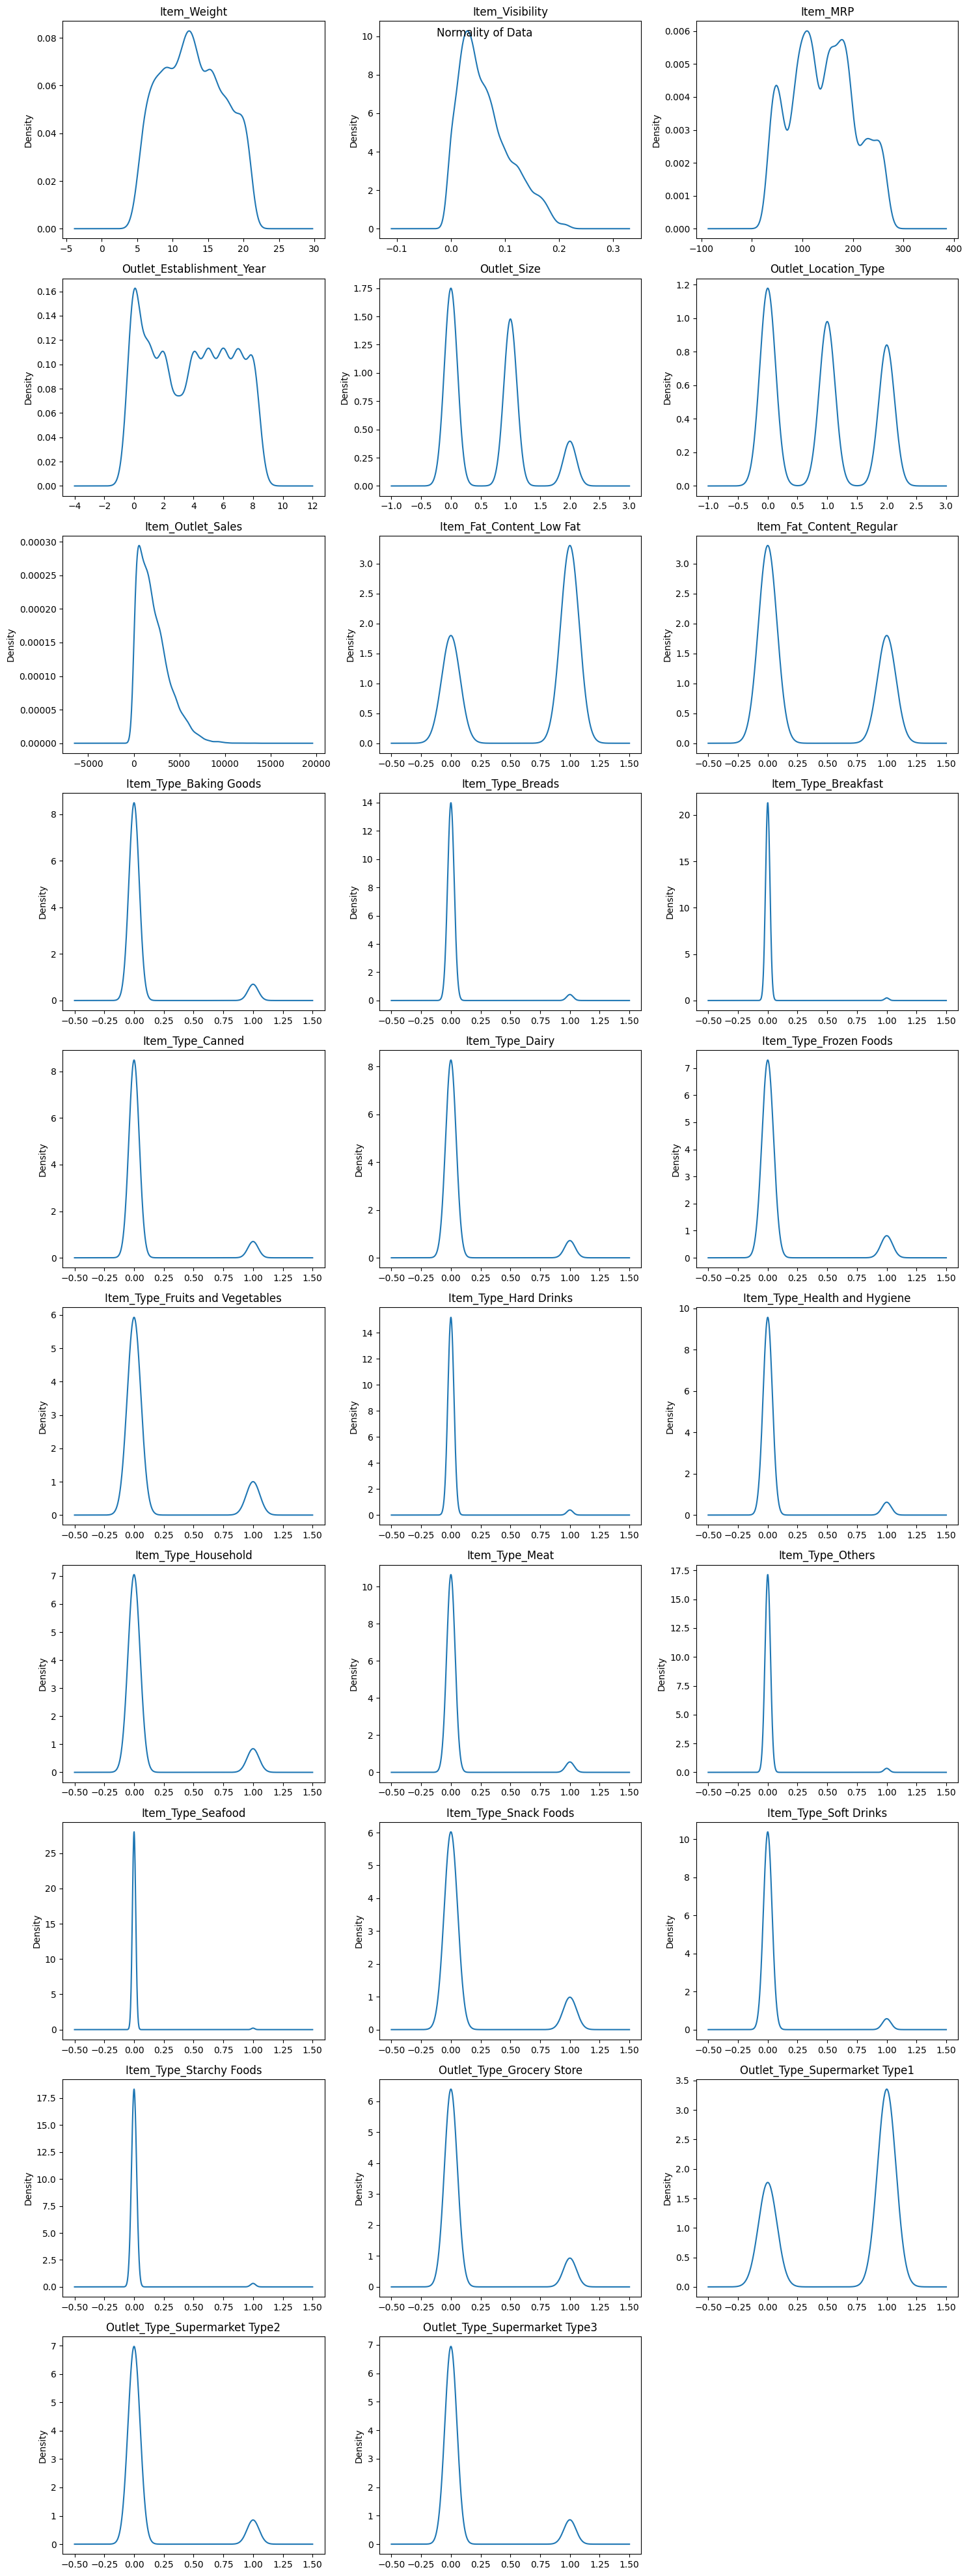

In [41]:
plt.figure(figsize = (15,40))
for i in range(0, 29) :
    col = sales_df.columns[i]
    plt.subplot(10, 3, i+1)
    sales_df[col].plot(kind = 'kde')
    plt.title(col)
    
plt.suptitle('Normality of Data')
plt.tight_layout()
plt.show()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Item_Outlet_Sales,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Type_Baking Goods,...,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
Item_Outlet_Sales,0.008164,-0.0903,0.567574,-0.025525,0.176931,-0.089367,1.0,-0.018719,0.018719,-0.038381,...,-0.002995,-0.021267,0.00738,0.022782,-0.02404,0.015039,-0.411727,0.108765,-0.038059,0.311192


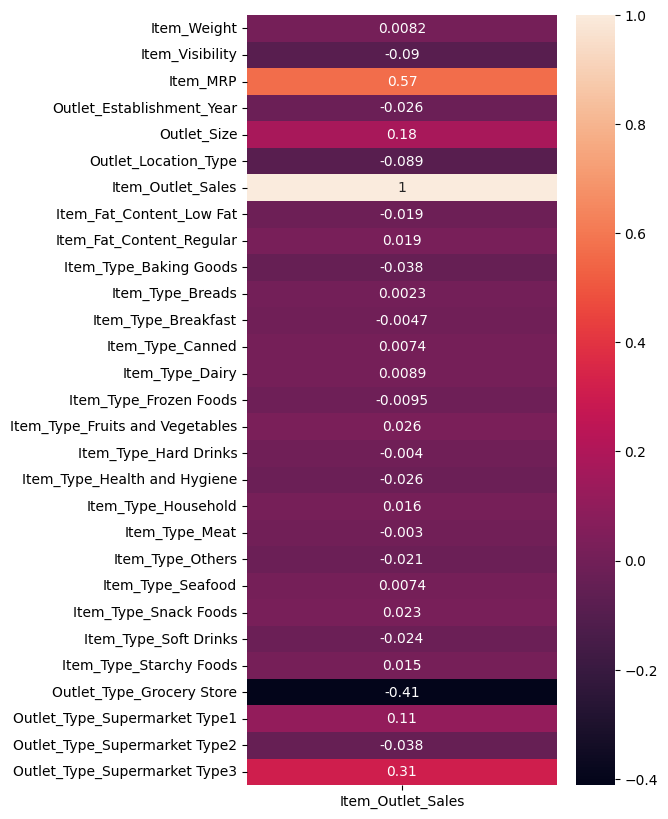

In [42]:
plt.figure(figsize = (5, 10))
relation = sales_df.corr().loc[['Item_Outlet_Sales'],:]
sns.heatmap(sales_df.corr().loc[:,['Item_Outlet_Sales']], annot = True)
relation

# 5. Model Training & Evaluation

##### Data Splitting

In [43]:
x = sales_df.drop('Item_Outlet_Sales', axis = 1)
y = sales_df['Item_Outlet_Sales']
y.head()

0    3735.1380
1     443.4228
2    2097.2700
3     732.3800
4     994.7052
Name: Item_Outlet_Sales, dtype: float64

##### Scaling (Normalization)

In [44]:
normal_data = MinMaxScaler()
data = normal_data.fit_transform(x)
x_normal = pd.DataFrame(data, columns = x.columns)
x_normal.head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Type_Baking Goods,Item_Type_Breads,...,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
0,0.282525,0.072868,0.927507,0.500,0.5,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.081274,0.087538,0.072068,1.000,0.5,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,0.770765,0.076104,0.468288,0.500,0.5,1.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.871986,0.000000,0.640093,0.375,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.260494,0.000000,0.095805,0.125,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


##### Scaling(Standarization)

In [45]:
std_data = StandardScaler()
data = std_data.fit_transform(x)
x_std = pd.DataFrame(data, columns = x.columns)
x_std.head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Type_Baking Goods,Item_Type_Breads,...,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
0,-0.821178,-1.017488,1.747454,0.076668,0.555221,1.369334,0.738147,-0.738147,-0.286855,-0.174193,...,-0.229090,-0.142232,-0.086982,-0.404805,-0.234708,-0.132935,-0.381529,0.726802,-0.349551,-0.351028
1,-1.604314,-0.948796,-1.489023,1.541783,0.555221,-1.091569,-1.354743,1.354743,-0.286855,-0.174193,...,-0.229090,-0.142232,-0.086982,-0.404805,4.260611,-0.132935,-0.381529,-1.375891,2.860816,-0.351028
2,1.078738,-1.002334,0.010040,0.076668,0.555221,1.369334,0.738147,-0.738147,-0.286855,-0.174193,...,4.365102,-0.142232,-0.086982,-0.404805,-0.234708,-0.132935,-0.381529,0.726802,-0.349551,-0.351028
3,1.472623,-1.358667,0.660050,-0.289611,-0.931007,-1.091569,-1.354743,1.354743,-0.286855,-0.174193,...,-0.229090,-0.142232,-0.086982,-0.404805,-0.234708,-0.132935,2.621031,-1.375891,-0.349551,-0.351028
4,-0.906906,-1.358667,-1.399220,-1.022168,2.041449,-1.091569,0.738147,-0.738147,-0.286855,-0.174193,...,-0.229090,-0.142232,-0.086982,-0.404805,-0.234708,-0.132935,-0.381529,0.726802,-0.349551,-0.351028


##### Train test Split

In [46]:
x_train, x_test, y_train, y_test  = train_test_split(x, y, test_size = 0.25, random_state = 7)
y_train.head()

2699    3621.9520
7890    2554.0088
3168    2885.5772
3408      67.9116
7632      41.9454
Name: Item_Outlet_Sales, dtype: float64

##### Train test Split(normalisation)

In [47]:
x_normal_train, x_normal_test, y_train, y_test  = train_test_split(x_normal, y, test_size = 0.25, random_state = 7)
x_normal_train.head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Type_Baking Goods,Item_Type_Breads,...,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
2699,0.288181,0.722904,0.826754,0.125,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
7890,0.240845,0.315147,0.254351,0.750,0.0,0.5,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3168,0.413516,0.080110,0.426882,0.250,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3408,0.874963,0.821071,0.019804,0.375,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
7632,0.562370,0.184926,0.051594,0.375,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


##### Train test Split (Standadiation)

In [48]:
x_std_train, x_std_test, y_train, y_test  = train_test_split(x_std, y, test_size = 0.25, random_state = 7)
x_std_train.head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Type_Baking Goods,Item_Type_Breads,...,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
2699,-0.799167,2.026095,1.366264,-1.022168,2.041449,-1.091569,0.738147,-0.738147,-0.286855,-0.174193,...,-0.22909,-0.142232,-0.086982,-0.404805,4.260611,-0.132935,-0.381529,0.726802,-0.349551,-0.351028
7890,-0.983366,0.116905,-0.799375,0.809225,-0.931007,0.138882,0.738147,-0.738147,-0.286855,-0.174193,...,-0.22909,-0.142232,-0.086982,-0.404805,-0.234708,-0.132935,-0.381529,0.726802,-0.349551,-0.351028
3168,-0.311444,-0.983579,-0.146619,-0.655889,-0.931007,1.369334,0.738147,-0.738147,-0.286855,-0.174193,...,-0.22909,-0.142232,-0.086982,-0.404805,-0.234708,-0.132935,-0.381529,0.726802,-0.349551,-0.351028
3408,1.484208,2.485731,-1.686761,-0.289611,-0.931007,-1.091569,0.738147,-0.738147,-0.286855,-0.174193,...,-0.22909,-0.142232,-0.086982,-0.404805,-0.234708,-0.132935,2.621031,-1.375891,-0.349551,-0.351028
7632,0.267798,-0.492812,-1.566487,-0.289611,-0.931007,-1.091569,0.738147,-0.738147,-0.286855,-0.174193,...,-0.22909,-0.142232,-0.086982,-0.404805,-0.234708,-0.132935,2.621031,-1.375891,-0.349551,-0.351028


##### List of Result

In [49]:
model_name = []
train_accuracy = []
test_accuracy = []
bias = []
variance = []
remark = []

## 5.1 Linear Regression

In [50]:
linear_model = LinearRegression()
linear_model.fit(x_train, y_train)

LinearRegression()

##### Testing Accuracy

In [51]:
y_pred = linear_model.predict(x_test)

mse = mean_squared_error(y_test, y_pred)
print('Mean Squared Error :', mse)
rmse = np.sqrt(mse)
print('Root Mean Squared Error :', rmse)
mae = mean_absolute_error(y_test, y_pred)
print('Mean Absolute Error :', mae)
r2_val_1 = r2_score(y_test, y_pred)
print('Accuracy :', r2_val_1)

model_name.append('LinearRegression')
test_accuracy.append(np.around(r2_val_1, 6))

Mean Squared Error : 1352410.95790206
Root Mean Squared Error : 1162.9320521432282
Mean Absolute Error : 854.5292663472214
Accuracy : 0.5427823401646741


##### Training Evaluation

In [52]:
y_pred = linear_model.predict(x_train)

mse = mean_squared_error(y_train, y_pred)
print('Mean Squared Error :', mse)
rmse = np.sqrt(mse)
print('Root Mean Squared Error :', rmse)
mae = mean_absolute_error(y_train, y_pred)
print('Mean Absolute Error :', mae)
r2_val_2 = r2_score(y_train, y_pred)
print('Accuracy :', r2_val_2)

train_accuracy.append(np.around(r2_val_2, 6))
bias.append(1 - r2_val_2)
variance.append(r2_val_2 - r2_val_1)

Mean Squared Error : 1246057.92663186
Root Mean Squared Error : 1116.2696478144785
Mean Absolute Error : 831.8195121792752
Accuracy : 0.5697049116150893


### 5.1.1 With Normatisation

In [53]:
linear_normal_model = LinearRegression()
linear_normal_model.fit(x_normal_train, y_train)

LinearRegression()

##### Testing Evaluation

In [54]:
y_pred = linear_normal_model.predict(x_normal_test)

mse = mean_squared_error(y_test, y_pred)
print('Mean Squared Error :', mse)
rmse = np.sqrt(mse)
print('Root Mean Squared Error :', rmse)
mae = mean_absolute_error(y_test, y_pred)
print('Mean Absolute Error :', mae)
r2_val_1 = r2_score(y_test, y_pred)
print('Accuracy :', r2_val_1)

model_name.append('LinearRegression_Normalization')
test_accuracy.append(np.around(r2_val_1, 6))

Mean Squared Error : 1352420.7520236364
Root Mean Squared Error : 1162.9362630959774
Mean Absolute Error : 854.5687185358986
Accuracy : 0.5427790290074248


##### Training Evaluation

In [55]:
y_pred = linear_normal_model.predict(x_normal_train)

mse = mean_squared_error(y_train, y_pred)
print('Mean Squared Error :', mse)
rmse = np.sqrt(mse)
print('Root Mean Squared Error :', rmse)
mae = mean_absolute_error(y_train, y_pred)
print('Mean Absolute Error :', mae)
r2_val_2 = r2_score(y_train, y_pred)
print('Accuracy :', r2_val_2)

train_accuracy.append(np.around(r2_val_2, 6))
bias.append(1 - r2_val_2)
variance.append(r2_val_2 - r2_val_1)

Mean Squared Error : 1246059.2697157748
Root Mean Squared Error : 1116.2702494090645
Mean Absolute Error : 831.8482652065084
Accuracy : 0.569704447814491


### 5.1.2 With Standardisation

In [56]:
linear_std_model = LinearRegression()
linear_std_model.fit(x_std_train, y_train)

LinearRegression()

##### Testing Evaluation

In [57]:
y_pred = linear_std_model.predict(x_std_test)

mse = mean_squared_error(y_test, y_pred)
print('Mean Squared Error :', mse)
rmse = np.sqrt(mse)
print('Root Mean Squared Error :', rmse)
mae = mean_absolute_error(y_test, y_pred)
print('Mean Absolute Error :', mae)
r2_val_1 = r2_score(y_test, y_pred)
print('Accuracy :', r2_val_1)

model_name.append('LinearRegression_Standardisation')
test_accuracy.append(np.around(r2_val_1, 6))

Mean Squared Error : 1351557.2239350867
Root Mean Squared Error : 1162.564933212372
Mean Absolute Error : 854.4452610839915
Accuracy : 0.543070967112142


##### Training Evalution

In [58]:
y_pred = linear_std_model.predict(x_std_train)

mse = mean_squared_error(y_train, y_pred)
print('Mean Squared Error :', mse)
rmse = np.sqrt(mse)
print('Root Mean Squared Error :', rmse)
mae = mean_absolute_error(y_train, y_pred)
print('Mean Absolute Error :', mae)
r2_val_2 = r2_score(y_train, y_pred)
print('Accuracy :', r2_val_2)

train_accuracy.append(np.around(r2_val_2, 6))
bias.append(1 - r2_val_2)
variance.append(r2_val_2 - r2_val_1)

Mean Squared Error : 1246244.2946949129
Root Mean Squared Error : 1116.3531227595115
Mean Absolute Error : 831.9800436579659
Accuracy : 0.5696405540435435


## 5.2 KNeighborsRegressor

### 5.2.1 Hyperparameter Tuning with Normalization

In [59]:
knn_model = KNeighborsRegressor()

parameter = {'n_neighbors' : np.arange(3,31,2), 'p' : [1, 2]}

gscv_knn = GridSearchCV(knn_model, parameter, cv = 5)
gscv_knn.fit(x_normal_train, y_train)
knn_normal_model = gscv_knn.best_estimator_
knn_normal_model

KNeighborsRegressor(n_neighbors=9)

##### testing Evaluation

In [60]:
y_pred = knn_normal_model.predict(x_normal_test)

mse = mean_squared_error(y_test, y_pred)
print('Mean Squared Error :', mse)
rmse = np.sqrt(mse)
print('Root Mean Squared Error :', rmse)
mae = mean_absolute_error(y_test, y_pred)
print('Mean Absolute Error :', mae)
r2_val_1 = r2_score(y_test, y_pred)
print('Accuracy :', r2_val_1)

model_name.append('KNeighborsRegressor_Normalization')
test_accuracy.append(np.around(r2_val_1, 6))

Mean Squared Error : 1576914.4488190177
Root Mean Squared Error : 1255.7525428280119
Mean Absolute Error : 897.9387257312686
Accuracy : 0.466883102479448


##### Training Evaluation

In [61]:
y_pred = knn_normal_model.predict(x_normal_train)

mse = mean_squared_error(y_train, y_pred)
print('Mean Squared Error :', mse)
rmse = np.sqrt(mse)
print('Root Mean Squared Error :', rmse)
mae = mean_absolute_error(y_train, y_pred)
print('Mean Absolute Error :', mae)
r2_val_2 = r2_score(y_train, y_pred)
print('Accuracy :', r2_val_2)

train_accuracy.append(np.around(r2_val_2, 6))
bias.append(1 - r2_val_2)
variance.append(r2_val_2 - r2_val_1)

Mean Squared Error : 1135646.196749953
Root Mean Squared Error : 1065.6670196407285
Mean Absolute Error : 769.4671825789183
Accuracy : 0.6078328541872988


### 5.2.2 Hyperparameter tuning with standardisation

In [62]:
knn_model = KNeighborsRegressor()

parameter = {'n_neighbors' : np.arange(3,31,2), 'p' : [1, 2]}

gscv_knn = GridSearchCV(knn_model, parameter, cv = 5)
gscv_knn.fit(x_std_train, y_train)
knn_std_model = gscv_knn.best_estimator_
knn_std_model

KNeighborsRegressor(n_neighbors=7)

##### Testing Evaluation

In [63]:
y_pred = knn_std_model.predict(x_std_test)

mse = mean_squared_error(y_test, y_pred)
print('Mean Squared Error :', mse)
rmse = np.sqrt(mse)
print('Root Mean Squared Error :', rmse)
mae = mean_absolute_error(y_test, y_pred)
print('Mean Absolute Error :', mae)
r2_val_1 = r2_score(y_test, y_pred)
print('Accuracy :', r2_val_1)

model_name.append('KNeighborsRegressor_Standardisation')
test_accuracy.append(np.around(r2_val_1, 6))

Mean Squared Error : 1579850.792789063
Root Mean Squared Error : 1256.9211561546185
Mean Absolute Error : 898.764343916337
Accuracy : 0.46589039511441865


##### Training Evaluation

In [64]:
y_pred = knn_std_model.predict(x_std_train)

mse = mean_squared_error(y_train, y_pred)
print('Mean Squared Error :', mse)
rmse = np.sqrt(mse)
print('Root Mean Squared Error :', rmse)
mae = mean_absolute_error(y_train, y_pred)
print('Mean Absolute Error :', mae)
r2_val_2 = r2_score(y_train, y_pred)
print('Accuracy :', r2_val_2)

train_accuracy.append(np.around(r2_val_2, 6))
bias.append(1 - r2_val_2)
variance.append(r2_val_2 - r2_val_1)

Mean Squared Error : 1081594.9402968064
Root Mean Squared Error : 1039.997567447543
Mean Absolute Error : 748.381520311103
Accuracy : 0.6264981101723792


## 5.3 DecisionTreeRegressor

### 5.3.1 Hyperparameter

In [65]:
dt_model = DecisionTreeRegressor(random_state = 7)
dt_model.fit(x_train, y_train)

DecisionTreeRegressor(random_state=7)

In [ ]:
plt.figure(figsize = (50, 50 ))
plot_tree(dt_model, feature_names = x.columns, filled = True)
plt.savefig(r'G:\DataScience\Assignments Solutions\Regression\Sales_Data\Statics\Tree_Without_Hyperparameter.png')

In [ ]:
dt_hyper_model = DecisionTreeRegressor(random_state = 7)

parameter = {'criterion' : ['mse', 'mae'],
             'max_depth' : np.arange(15, 28),
             'min_samples_split' : np.arange(10, 25),
             'min_samples_leaf' : np.arange(5,10)}

rscv_dt_model = RandomizedSearchCV(dt_hyper_model, parameter, cv = 7)
rscv_dt_model.fit(x_train, y_train)
dt_hyper_model = rscv_dt_model.best_estimator_
dt_hyper_model


##### Testing Evaluation

In [ ]:
y_pred = dt_hyper_model.predict(x_test)

mse = mean_squared_error(y_test, y_pred)
print('Mean Squared Error :', mse)
rmse = np.sqrt(mse)
print('Root Mean Squared Error :', rmse)
mae = mean_absolute_error(y_test, y_pred)
print('Mean Absolute Error :', mae)
r2_val_1 = r2_score(y_test, y_pred)
print('Accuracy :', r2_val_1)

model_name.append('DecisionTreeRegressor_Hyperparameter')
test_accuracy.append(np.around(r2_val_1, 6))

##### Training Evaluation

In [ ]:
y_pred = dt_hyper_model.predict(x_train)

mse = mean_squared_error(y_train, y_pred)
print('Mean Squared Error :', mse)
rmse = np.sqrt(mse)
print('Root Mean Squared Error :', rmse)
mae = mean_absolute_error(y_train, y_pred)
print('Mean Absolute Error :', mae)
r2_val_2 = r2_score(y_train, y_pred)
print('Accuracy :', r2_val_2)

train_accuracy.append(np.around(r2_val_2, 6))
bias.append(1 - r2_val_2)
variance.append(r2_val_2 - r2_val_1)

In [ ]:
plt.figure(figsize = (50, 50 ))
plot_tree(dt_hyper_model, feature_names = x.columns, filled = True)
plt.savefig(r'G:\DataScience\Assignments Solutions\Regression\Sales_Data\Statics\Tree_With_Hyperparameter.png')

### 5.3.2 Pruning

In [ ]:
train_list = []
test_list = []
ccp_alpha_val = dt_model.cost_complexity_pruning_path(x_train, y_train)['ccp_alphas']

for ccp_alpha in ccp_alpha_val:
    dt_reg_model = DecisionTreeRegressor(random_state=10,ccp_alpha=ccp_alpha)
    dt_reg_model.fit(x_train, y_train)
    train_list.append(dt_reg_model.score(x_train, y_train))
    test_list.append(dt_reg_model.score(x_test, y_test))

index = np.where(test_list == max(test_list))
best_ccp = ccp_alpha_val[index][0]
best_ccp

In [ ]:
fig,ax = plt.subplots()
ax.plot(ccp_alpha_val, train_list, label = "Training Data Accuracy")
ax.plot(ccp_alpha_val, test_list, label = "Testing Data Accuracy")
ax.legend()

In [ ]:
dt_prun_model = DecisionTreeRegressor(ccp_alpha = best_ccp, random_state = 7)
dt_prun_model.fit(x_train, y_train)

##### Testing Evaluation

In [ ]:
y_pred = dt_prun_model.predict(x_test)

mse = mean_squared_error(y_test, y_pred)
print('Mean Squared Error :', mse)
rmse = np.sqrt(mse)
print('Root Mean Squared Error :', rmse)
mae = mean_absolute_error(y_test, y_pred)
print('Mean Absolute Error :', mae)
r2_val_1 = r2_score(y_test, y_pred)
print('Accuracy :', r2_val_1)

model_name.append('DecisionTreeRegressor_Pruning')
test_accuracy.append(np.around(r2_val_1, 6))

##### Training Evaluation

In [ ]:
y_pred = dt_prun_model.predict(x_train)

mse = mean_squared_error(y_train, y_pred)
print('Mean Squared Error :', mse)
rmse = np.sqrt(mse)
print('Root Mean Squared Error :', rmse)
mae = mean_absolute_error(y_train, y_pred)
print('Mean Absolute Error :', mae)
r2_val_2 = r2_score(y_train, y_pred)
print('Accuracy :', r2_val_2)

train_accuracy.append(np.around(r2_val_2, 6))
bias.append(1 - r2_val_2)
variance.append(r2_val_2 - r2_val_1)

In [ ]:
plt.figure(figsize = (50, 50 ))
plot_tree(dt_prun_model, feature_names = x.columns, filled = True)
plt.savefig(r'G:\DataScience\Assignments Solutions\Regression\Sales_Data\Statics\Tree_With_Pruning.png')

## 5.4 Random Forest

In [ ]:
rf_model= RandomForestRegressor()
rf_model.fit(x_train, y_train)

##### Testing Evaluation

In [ ]:
y_pred = rf_model.predict(x_test)

mse = mean_squared_error(y_test, y_pred)
print('Mean Squared Error :', mse)
rmse = np.sqrt(mse)
print('Root Mean Squared Error :', rmse)
mae = mean_absolute_error(y_test, y_pred)
print('Mean Absolute Error :', mae)
r2_val_1 = r2_score(y_test, y_pred)
print('Accuracy :', r2_val_1)

model_name.append('RandomForestRegressor')
test_accuracy.append(np.around(r2_val_1, 6))

##### Training Evaluation

In [ ]:
y_pred = rf_model.predict(x_train)

mse = mean_squared_error(y_train, y_pred)
print('Mean Squared Error :', mse)
rmse = np.sqrt(mse)
print('Root Mean Squared Error :', rmse)
mae = mean_absolute_error(y_train, y_pred)
print('Mean Absolute Error :', mae)
r2_val_2 = r2_score(y_train, y_pred)
print('Accuracy :', r2_val_2)

train_accuracy.append(np.around(r2_val_2, 6))
bias.append(1 - r2_val_2)
variance.append(r2_val_2 - r2_val_1)

### 5.4.1 Hyperparameter

In [ ]:
rf_model= RandomForestRegressor()

parameters = {"n_estimators" :np.arange(10,100),
              "criterion" : ['mse','mae'],
              "max_depth" : np.arange(10, 28),
              "min_samples_split" : np.arange(10,25),
              "min_samples_leaf" : np.arange(5,10)}

rscv_rf_model = RandomizedSearchCV(rf_model,parameters,cv = 5)
rscv_rf_model.fit(x_train, y_train)
rf_hyper_model = rscv_rf_model.best_estimator_
rf_hyper_model

##### Testing Evaluation

In [ ]:
y_pred = rf_hyper_model.predict(x_test)

mse = mean_squared_error(y_test, y_pred)
print('Mean Squared Error :', mse)
rmse = np.sqrt(mse)
print('Root Mean Squared Error :', rmse)
mae = mean_absolute_error(y_test, y_pred)
print('Mean Absolute Error :', mae)
r2_val_1 = r2_score(y_test, y_pred)
print('Accuracy :', r2_val_1)

model_name.append('RandomForestRegressor_Hyperparameter')
test_accuracy.append(np.around(r2_val_1, 6))

##### Training Evaluation

In [ ]:
y_pred = rf_hyper_model.predict(x_train)

mse = mean_squared_error(y_train, y_pred)
print('Mean Squared Error :', mse)
rmse = np.sqrt(mse)
print('Root Mean Squared Error :', rmse)
mae = mean_absolute_error(y_train, y_pred)
print('Mean Absolute Error :', mae)
r2_val_2 = r2_score(y_train, y_pred)
print('Accuracy :', r2_val_2)

train_accuracy.append(np.around(r2_val_2, 6))
bias.append(1 - r2_val_2)
variance.append(r2_val_2 - r2_val_1)

## 5.5 AdaBoost

In [ ]:
adb_model = AdaBoostRegressor( random_state = 7)
adb_model.fit(x_train, y_train)

##### Testing Evaluation

In [ ]:
y_pred = adb_model.predict(x_test)

mse = mean_squared_error(y_test, y_pred)
print('Mean Squared Error :', mse)
rmse = np.sqrt(mse)
print('Root Mean Squared Error :', rmse)
mae = mean_absolute_error(y_test, y_pred)
print('Mean Absolute Error :', mae)
r2_val_1 = r2_score(y_test, y_pred)
print('Accuracy :', r2_val_1)

model_name.append('AdaBoostRegressor')
test_accuracy.append(np.around(r2_val_1, 6))

##### Training Evaluation

In [ ]:
y_pred = adb_model.predict(x_train)

mse = mean_squared_error(y_train, y_pred)
print('Mean Squared Error :', mse)
rmse = np.sqrt(mse)
print('Root Mean Squared Error :', rmse)
mae = mean_absolute_error(y_train, y_pred)
print('Mean Absolute Error :', mae)
r2_val_2 = r2_score(y_train, y_pred)
print('Accuracy :', r2_val_2)

train_accuracy.append(np.around(r2_val_2, 6))
bias.append(1 - r2_val_2)
variance.append(r2_val_2 - r2_val_1)

### 5.5.1 Hyperparameter

In [ ]:
parameters = {"n_estimators" : np.arange(10,100),
              "learning_rate" : np.arange(0,2,0.001)}

rscv_adb_model = RandomizedSearchCV(adb_model,parameters,cv= 3)
rscv_adb_model.fit(x_train, y_train)
adb_hyper_model = rscv_adb_model.best_estimator_
adb_hyper_model

##### Testing Evaluation

In [ ]:
y_pred = adb_hyper_model.predict(x_test)

mse = mean_squared_error(y_test, y_pred)
print('Mean Squared Error :', mse)
rmse = np.sqrt(mse)
print('Root Mean Squared Error :', rmse)
mae = mean_absolute_error(y_test, y_pred)
print('Mean Absolute Error :', mae)
r2_val_1 = r2_score(y_test, y_pred)
print('Accuracy :', r2_val_1)

model_name.append('AdaBoostRegressor_Hyperparameter')
test_accuracy.append(np.around(r2_val_1, 6))

##### Training Evaluation

In [ ]:
y_pred = adb_hyper_model.predict(x_train)

mse = mean_squared_error(y_train, y_pred)
print('Mean Squared Error :', mse)
rmse = np.sqrt(mse)
print('Root Mean Squared Error :', rmse)
mae = mean_absolute_error(y_train, y_pred)
print('Mean Absolute Error :', mae)
r2_val_2 = r2_score(y_train, y_pred)
print('Accuracy :', r2_val_2)

train_accuracy.append(np.around(r2_val_2, 6))
bias.append(1 - r2_val_2)
variance.append(r2_val_2 - r2_val_1)

# 6. Conclusion

##### Result of Models

In [ ]:
result = pd.DataFrame(list(zip(model_name, test_accuracy, train_accuracy, bias, variance)), 
                      columns = ['Model_name', 'test_accuracy', 'train_accuracy', 'bias', 'variance'])
result = result.sort_values(by = 'test_accuracy', ascending = False)
result

##### Best Model

In [ ]:
dt_prun_model

In [ ]:
with open('clf_model.pkl', 'wb') as f:
    pickle.dump(dt_prun_model, f)
    
json_data['Columns'] = list(x.columns)

with open('json_data.json', 'w') as f:
    json.dump(json_data, f)